In [1]:
import json
from static_checks.Checker import *
from common.path_utils import get_data_path
import pandas as pd
from plotnine import ggplot, aes, geom_point, theme_minimal, labs, scale_x_continuous, scale_y_continuous

c:\Users\abhim\AppData\Local\Programs\Python\Python311\Lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


LOCAL_CACHE: None
max_concurrent_queries set for global semaphore: 25
Resetting global semaphore, max concurrent queries: 25

 NO_CACHE 


 NO_CACHE 


 NO_CACHE 


 NO_CACHE 

The setting for WRITE_VERIFICATION in fq_body_generator.py: True


c:\Users\abhim\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydantic\_internal\_model_construction.py:54: UserWarning: `check_question_type` overrides an existing Pydantic `@field_validator` decorator
  warnings.warn(f'`{k}` overrides an existing Pydantic `{existing.decorator_info.decorator_repr}` decorator')


In [7]:
"""
An ItemForecast dict is a dict of the form:

{
    ...,
    elicited_prob: float,
    elicitation_metadata: {
        "P": ItemForecast,
        "check1": tuple_forecast,
        "check2": tuple_forecast,
        ...
    }
}

A tuple_forecast dict is a dict of the form:

{
    "P": ItemForecast,
    "Q": ItemForecast,
    ...
}

We want to write a function which, given a tuple_forecast, returns a TupleInconsistency dict of the form:

{
    viol: float,
    metadata: {
        "P": {
            "check1": TupleInconsistency,
            "check2": TupleInconsistency,
            ...
        },
        "Q": {
            "check1": TupleInconsistency,
            "check2": TupleInconsistency,
            ...
        },
        ...
    }
}

"""

checkers = {
    "NegChecker": NegChecker(),
    "ParaphraseChecker": ParaphraseChecker(),
    "AndChecker": AndChecker(),
    "OrChecker": OrChecker(),
    "AndOrChecker": AndOrChecker(),
    "ButChecker": ButChecker(),
    "CondChecker": CondChecker(),
    "CondCondChecker": CondCondChecker(),
    "ConsequenceChecker": ConsequenceChecker(),
}


def inconsistency(checker_name: str, tuple_forecast: dict[str, Any]):
   
    tuple_forecast_probs = {k: v['elicited_prob'] for k, v in tuple_forecast.items()}
    viol = checkers[checker_name].violation(tuple_forecast_probs)#, metric="frequentist"
    
    metadata = {}
    
    for k, item_forecast in tuple_forecast.items():
        if "elicitation_metadata" in item_forecast:
            elicitation_metadata = item_forecast["elicitation_metadata"]
            metadata[k] = {}
            for check_name, check_dict in elicitation_metadata.items():
                if check_name == "P":
                    continue
                check_dict_with_P = {"P": elicitation_metadata["P"]} | check_dict
                metadata[k][check_name] = inconsistency(check_name, check_dict_with_P)

    return {"viol": viol, "metadata": metadata}


def extract_viols(result: dict, checker_name: str):
    viols = []
    viols.append(result['viol'])
    result_next = result.get('metadata', {}).get('P', {}).get(checker_name, {})
    if result_next:
        viols.extend(extract_viols(result_next, checker_name))
    return viols

def plot_extracted_viols(viols):
    # Create a DataFrame with the violations and their indices
    df = pd.DataFrame({
        'Violation': viols,
        'Depth': range(len(viols)-1, -1, -1)  # Reverse order
    })
    
    # Create the plot
    plot = (ggplot(df, aes(x='Depth', y='Violation'))
            + geom_point(size=3)
            # + scale_y_continuous(limits=(0, 1))
            + labs(title='Violations by Depth',
                   x='Depth',
                   y='Violation')
            + theme_minimal())
    
    return plot

def load_tuple_forecasts(file_path):
    with open(file_path, 'r') as file:
        return [json.loads(line)['line'] for line in file]

C:\Users\abhim\AppData\Local\Temp\ipykernel_25796\3461125296.py:13: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


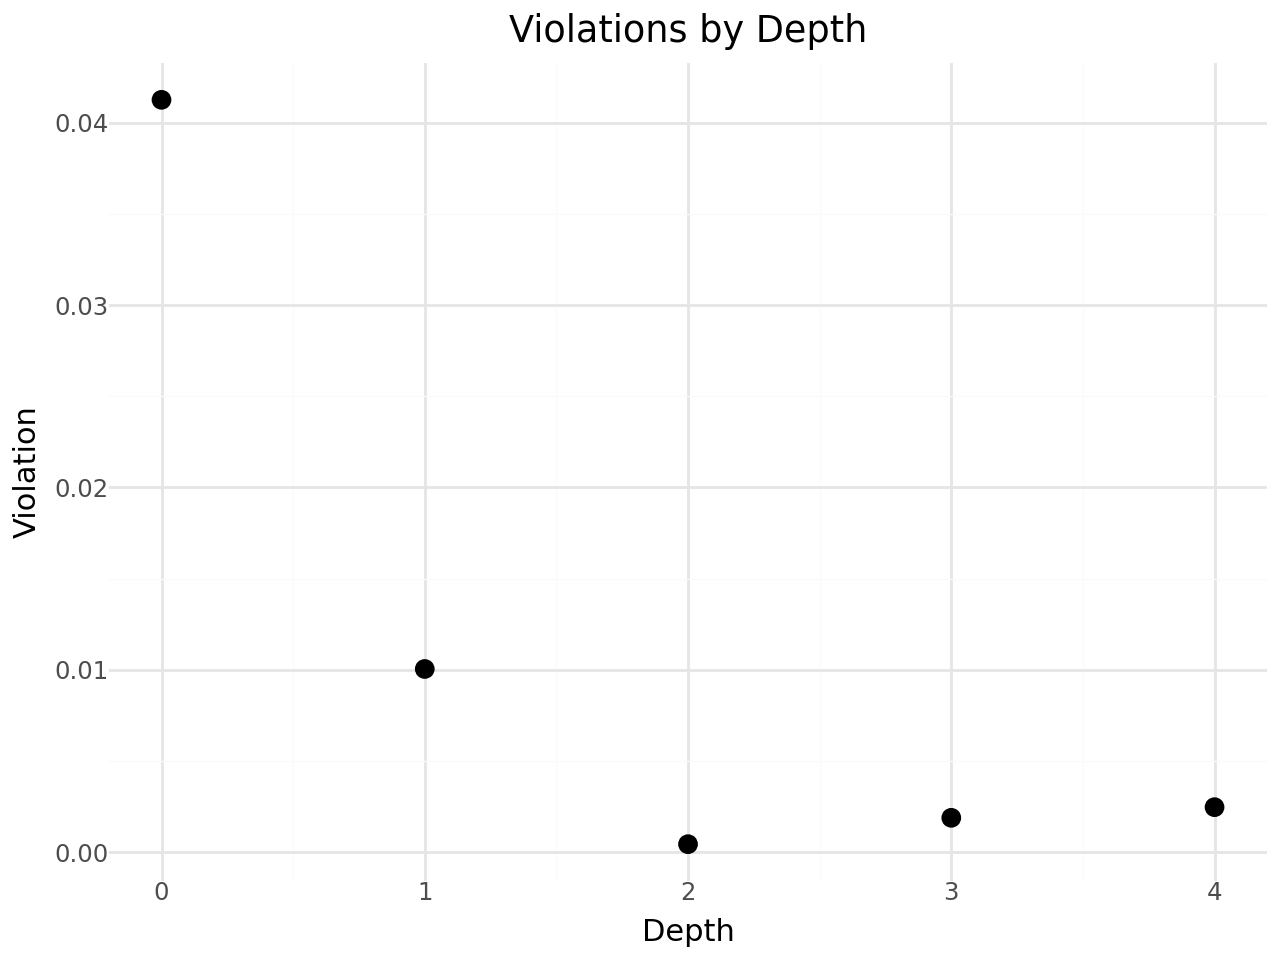

In [14]:
checker_name = "ParaphraseChecker"
file_paths = {
    # "NegChecker": get_data_path() / 'forecasts' / 'ConsistentForecaster_08-23-22-13' / 'NegChecker.jsonl',
    "NegChecker": get_data_path() / 'forecasts' / 'ConsistentForecaster_08-25-01-35' / 'NegChecker.jsonl',
    "ParaphraseChecker": get_data_path() / 'forecasts' / 'ConsistentForecaster_08-25-09-31' / 'ParaphraseChecker.jsonl'
    # "ParaphraseChecker": get_data_path() / 'forecasts' / 'ConsistentForecaster_08-24-07-53' / 'ParaphraseChecker.jsonl'
}

tuple_forecasts = load_tuple_forecasts(file_paths[checker_name])
result = inconsistency(checker_name, tuple_forecasts[0])
v=extract_viols(result, checker_name)
plot = plot_extracted_viols(v)
print(plot)

C:\Users\abhim\AppData\Local\Temp\ipykernel_25796\116036665.py:30: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


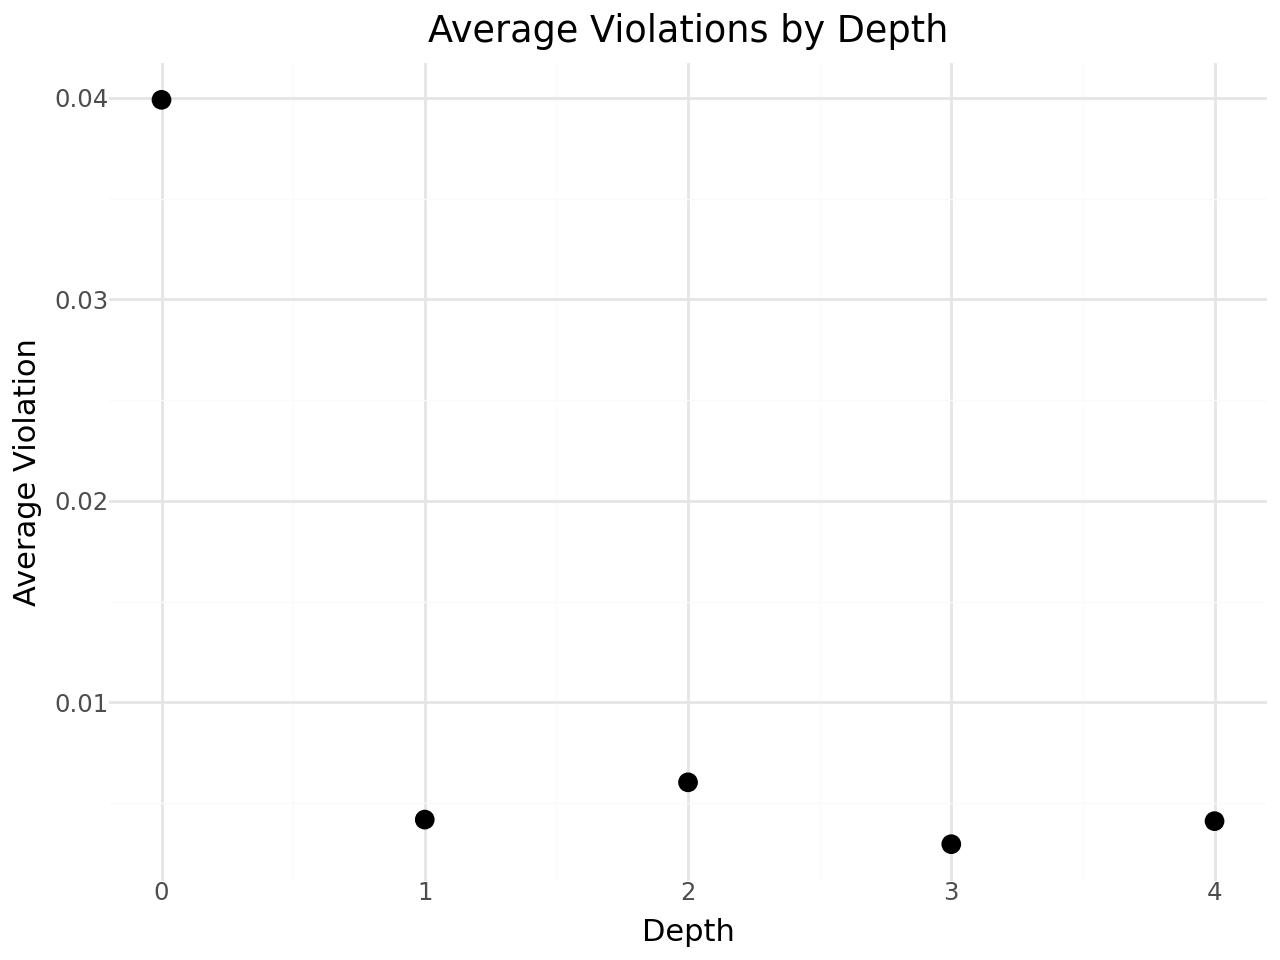

In [9]:
# Process all lines and collect violations
all_violations = []
for tuple_forecast in tuple_forecasts:
    result = inconsistency(checker_name, tuple_forecast)
    violations = extract_viols(result, checker_name)
    all_violations.append(violations)

# Calculate the average violations at each depth
max_depth = max(len(v) for v in all_violations)
avg_violations = []
for depth in range(max_depth):
    violations_at_depth = [v[depth] if depth < len(v) else np.nan for v in all_violations]
    avg_violations.append(np.nanmean(violations_at_depth))

# Create a DataFrame with the average violations
df_avg = pd.DataFrame({
    'Violation': avg_violations,
    'Depth': range(len(avg_violations)-1, -1, -1)  # Reverse order
})

# Create the plot for average violations
plot_avg = (ggplot(df_avg, aes(x='Depth', y='Violation'))
            + geom_point(size=3)
            # + geom_line()
            + labs(title='Average Violations by Depth',
                   x='Depth',
                   y='Average Violation')
            + theme_minimal())

print(plot_avg)
